In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sksurv.preprocessing import OneHotEncoder

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import matplotlib.pyplot as plt
import random

In [82]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

random.seed(43)

for i in va_y:
    if random.randint(0,10) < 9:
        i[0] = False

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y["Status"], random_state=0
)

min_idx = np.argmin(va_y_train['Survival_in_days'])
max_idx = np.argmax(va_y_train['Survival_in_days'])

va_y_train[min_idx]['Status'] = 0
va_y_train[max_idx]['Status'] = 0

va_y_train

array([( True,  20.), (False, 357.), (False,  18.), (False,  52.),
       (False, 340.), (False, 122.), ( True, 162.), (False, 123.),
       (False,  16.), (False, 182.), (False,   8.), (False, 117.),
       ( True,  53.), (False, 162.), (False,  31.), (False, 100.),
       (False,   7.), (False,  59.), (False, 143.), (False,   2.),
       ( True, 132.), (False,  51.), (False, 118.), (False,  56.),
       (False,  95.), (False,  43.), ( True,  54.), (False, 133.),
       (False,  97.), ( True, 384.), ( True, 111.), ( True, 177.),
       (False,  48.), (False,  19.), (False, 139.), (False, 587.),
       (False, 260.), (False, 103.), (False, 153.), ( True, 283.),
       (False, 117.), (False,  25.), (False, 231.), (False,  25.),
       (False,  36.), ( True,  84.), (False,  24.), ( True,  52.),
       (False, 392.), (False,  83.), (False,  13.), (False, 250.),
       (False,  27.), (False, 100.), ( True,  87.), (False,  52.),
       (False,  29.), (False,  49.), (False,  63.), ( True,  2

In [83]:
max(va_y_train[va_y_train['Status']]['Survival_in_days'])

389.0

In [84]:
va_y_train['

SyntaxError: unterminated string literal (detected at line 1) (1550109129.py, line 1)

In [85]:
from sklearn.model_selection import KFold

# Create KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=41)

# Example data indices
data_indices = range(100)  # Assuming you have 100 samples

# Iterate over the folds and print the train-test indices
fold_index = 1
for train_indices, test_indices in kf.split(data_indices):
    print(f"Fold {fold_index}:")
    print("Train indices:", train_indices)
    print("Test indices:", test_indices)
    print()
    fold_index += 1

Fold 1:
Train indices: [ 1  3  4  5  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 26 28 29 30
 31 34 35 36 38 39 40 41 43 44 45 46 47 48 49 50 51 52 53 55 56 58 59 61
 62 63 64 65 66 67 69 70 71 73 74 75 76 77 80 81 82 83 84 85 86 87 88 89
 90 91 92 95 96 97 98 99]
Test indices: [ 0  2  6 16 24 25 27 32 33 37 42 54 57 60 68 72 78 79 93 94]

Fold 2:
Train indices: [ 0  1  2  3  4  5  6  8  9 10 12 13 14 16 17 19 20 21 22 23 24 25 26 27
 28 30 31 32 33 34 35 36 37 38 39 42 43 44 45 46 47 50 51 52 53 54 55 56
 57 58 59 60 61 62 64 65 68 69 70 71 72 73 74 75 77 78 79 80 81 84 85 88
 89 92 93 94 95 96 97 98]
Test indices: [ 7 11 15 18 29 40 41 48 49 63 66 67 76 82 83 86 87 90 91 99]

Fold 3:
Train indices: [ 0  1  2  3  4  5  6  7 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27 28
 29 32 33 34 35 37 39 40 41 42 44 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 63 64 65 66 67 68 70 71 72 74 75 76 78 79 80 82 83 84 85 86 87 88 89
 90 91 92 93 94 97 98 99]
Test indices: [ 8  9 10 14 21 30 31 36 38 

In [86]:
from sklearn.model_selection import KFold

class CustomKFold(KFold):
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y=None, groups=None):
        for train_index, test_index in super().split(X, y, groups):
            # Ensure m is always in the training set
            #if X[train_index].max() < X[test_index].max():
            #    train_index = list(train_index) + [test_index[X[test_index].argmax()]]
            yield train_index, test_index

# Usage example:
kf = CustomKFold(n_splits=5, shuffle=True, random_state=41)

# Example data indices
data_indices = range(100)  # Assuming you have 100 samples

# Iterate over the folds and print the train-test indices
fold_index = 1
for train_indices, test_indices in kf.split(data_indices):
    print(f"Fold {fold_index}:")
    print("Train indices:", train_indices)
    print("Test indices:", test_indices)
    print()
    fold_index += 1

Fold 1:
Train indices: [ 1  3  4  5  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 26 28 29 30
 31 34 35 36 38 39 40 41 43 44 45 46 47 48 49 50 51 52 53 55 56 58 59 61
 62 63 64 65 66 67 69 70 71 73 74 75 76 77 80 81 82 83 84 85 86 87 88 89
 90 91 92 95 96 97 98 99]
Test indices: [ 0  2  6 16 24 25 27 32 33 37 42 54 57 60 68 72 78 79 93 94]

Fold 2:
Train indices: [ 0  1  2  3  4  5  6  8  9 10 12 13 14 16 17 19 20 21 22 23 24 25 26 27
 28 30 31 32 33 34 35 36 37 38 39 42 43 44 45 46 47 50 51 52 53 54 55 56
 57 58 59 60 61 62 64 65 68 69 70 71 72 73 74 75 77 78 79 80 81 84 85 88
 89 92 93 94 95 96 97 98]
Test indices: [ 7 11 15 18 29 40 41 48 49 63 66 67 76 82 83 86 87 90 91 99]

Fold 3:
Train indices: [ 0  1  2  3  4  5  6  7 11 12 13 15 16 17 18 19 20 22 23 24 25 26 27 28
 29 32 33 34 35 37 39 40 41 42 44 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 63 64 65 66 67 68 70 71 72 74 75 76 78 79 80 82 83 84 85 86 87 88 89
 90 91 92 93 94 97 98 99]
Test indices: [ 8  9 10 14 21 30 31 36 38 

In [87]:
data = np.array([(True, 10), (False, 15), (True, 20)], dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

# Filter the array to include only samples where Status is 1
filtered_data = data[data['Status']]

# Get the index of the sample with the maximum Survival_in_days among the filtered data
index_of_max_survival = np.argmax(filtered_data['Survival_in_days'])

# Get the index of the original array corresponding to the index in the filtered data
original_index = np.where(data['Status'] == True)[0][index_of_max_survival]
original_index

2

In [88]:
a = np.array([1,2,3])
a = np.delete(a, 2)
a

array([1, 2])

In [89]:
from sklearn.model_selection import BaseCrossValidator
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sksurv.metrics import cumulative_dynamic_auc, as_concordance_index_ipcw_scorer
import numpy as np

class CustomKFold(KFold):
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y=None, groups=None):

        filtered_data = y[y['Status'] == True]

        # Get the index of the sample with the maximum Survival_in_days among the filtered data
        index_of_max_survival = np.argmax(filtered_data['Survival_in_days'])
        
        # Get the index of the original array corresponding to the index in the filtered data
        original_max_index = np.where(y['Status'] == True)[0][index_of_max_survival]
                
        for train_index, test_index in super().split(X, y, groups):
            print(train_index)
            print(test_index)
            # Ensure m is always in the training set
            #if X[train_index].max() < X[test_index].max():
            #    train_index = list(train_index) + [test_index[X[test_index].argmax()]]
            if original_max_index in test_index:
                test_index = np.delete(test_index, np.where(test_index == original_max_index))
                train_index = np.append(train_index, original_max_index)
            yield train_index, test_index

    def get_n_splits(self, X, y, groups=None):
            return self.n_splits

# Usage example:
cv = CustomKFold(n_splits=5, shuffle=True, random_state=41)

estimated_alphas = np.arange(0.0001, 0.1 + 0.005, 0.0005)

encoder = OneHotEncoder()

# Fit and transform the data
va_x_train = encoder.fit_transform(va_x_train)

gcv = GridSearchCV(
    as_concordance_index_ipcw_scorer(CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model=True, max_iter=50000, normalize=False)),
    param_grid={"estimator__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0,
    n_jobs=-1,
).fit(va_x_train, va_y_train)


[  1   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  26  28  29  30  31  33  34  35  36  38  40  41  43  44  45
  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64
  65  67  68  69  70  71  74  75  76  77  78  79  80  81  82  84  85  86
  87  88  89  91  92  93  94  96  98  99 100 102 104 106 107]
[  0   2   6  24  25  27  32  37  39  42  54  66  72  73  83  90  95  97
 101 103 105 108]
[  0   1   2   3   4   5   6   8   9  10  12  13  14  17  19  20  21  22
  23  24  25  26  27  28  30  31  32  34  35  36  37  38  39  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  58  59  61  64  65  66
  69  70  72  73  74  75  76  77  78  80  81  83  84  85  86  87  88  89
  90  91  94  95  96  97  98 101 102 103 104 105 106 107 108]
[  7  11  15  16  18  29  33  40  41  57  60  62  63  67  68  71  79  82
  92  93  99 100]
[  0   1   2   3   4   5   6   7  11  12  13  15  16  17  18  19  20  22
  23  24  25  26  27  28  29  32  33 

In [90]:
va_y_train[va_y_train['Status']]

array([( True,  20.), ( True, 162.), ( True,  53.), ( True, 132.),
       ( True,  54.), ( True, 384.), ( True, 111.), ( True, 177.),
       ( True, 283.), ( True,  84.), ( True,  52.), ( True,  87.),
       ( True,  21.), ( True,  61.), ( True, 112.), ( True, 389.),
       ( True, 287.), ( True, 314.), ( True,  10.), ( True,  12.),
       ( True,  95.), ( True,  80.), ( True,  20.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [91]:
19.19000053 < 20.63999939

True

In [92]:
va_y_train[0] = (True, 0.000001)
va_y_train[1] = (True, 17.90999985)
va_y_train[2] = (True, 20000)
va_y_train

array([( True, 1.00000000e-06), ( True, 1.79099998e+01),
       ( True, 2.00000000e+04), (False, 5.20000000e+01),
       (False, 3.40000000e+02), (False, 1.22000000e+02),
       ( True, 1.62000000e+02), (False, 1.23000000e+02),
       (False, 1.60000000e+01), (False, 1.82000000e+02),
       (False, 8.00000000e+00), (False, 1.17000000e+02),
       ( True, 5.30000000e+01), (False, 1.62000000e+02),
       (False, 3.10000000e+01), (False, 1.00000000e+02),
       (False, 7.00000000e+00), (False, 5.90000000e+01),
       (False, 1.43000000e+02), (False, 2.00000000e+00),
       ( True, 1.32000000e+02), (False, 5.10000000e+01),
       (False, 1.18000000e+02), (False, 5.60000000e+01),
       (False, 9.50000000e+01), (False, 4.30000000e+01),
       ( True, 5.40000000e+01), (False, 1.33000000e+02),
       (False, 9.70000000e+01), ( True, 3.84000000e+02),
       ( True, 1.11000000e+02), ( True, 1.77000000e+02),
       (False, 4.80000000e+01), (False, 1.90000000e+01),
       (False, 1.39000000e+02),

In [93]:
encoder = OneHotEncoder()

# Fit and transform the data
va_x_train = encoder.fit_transform(va_x_train)

In [103]:
cph = CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model = True, max_iter = 50000, alpha_min_ratio = 0.01)
cph.fit(va_x_train, va_y_train)
alphas = cox.alphas_
cox.score(va_x_train, va_y_train)
alphas

array([3.04311676, 2.90480241, 2.77277466, 2.64674777, 2.526449  ,
       2.41161799, 2.30200623, 2.1973765 , 2.09750234, 2.00216763,
       1.91116602, 1.82430057, 1.7413833 , 1.66223474, 1.5866836 ,
       1.51456638, 1.445727  , 1.38001648, 1.3172926 , 1.25741962,
       1.20026796, 1.14571393, 1.09363946, 1.04393186, 0.99648355,
       0.95119183, 0.90795869, 0.86669057, 0.82729815, 0.78969617,
       0.75380326, 0.71954174, 0.68683745, 0.65561963, 0.62582071,
       0.59737619, 0.57022452, 0.54430694, 0.51956735, 0.49595221,
       0.47341042, 0.45189318, 0.43135394, 0.41174824, 0.39303364,
       0.37516966, 0.35811762, 0.34184062, 0.32630344, 0.31147244,
       0.29731554, 0.28380209, 0.27090284, 0.25858989, 0.24683658,
       0.23561748, 0.2249083 , 0.21468587, 0.20492807, 0.19561377,
       0.18672282, 0.17823598, 0.17013488, 0.16240199, 0.15502057,
       0.14797464, 0.14124897, 0.13482898, 0.1287008 , 0.12285115,
       0.11726737, 0.11193739, 0.10684966, 0.10199318, 0.09735

In [101]:
from sklearn.model_selection import KFold, GridSearchCV
from sksurv.metrics import cumulative_dynamic_auc, as_concordance_index_ipcw_scorer

estimated_alphas = np.arange(0.0001, 0.1 + 0.005, 0.0005)

cv = KFold(n_splits=3, shuffle = True, random_state = 40)
gcv = GridSearchCV(
    as_concordance_index_ipcw_scorer(CoxnetSurvivalAnalysis(l1_ratio=0.5, fit_baseline_model = True, max_iter = 50000, normalize = False)),
    param_grid = {"estimator__alphas": [[v] for v in estimated_alphas]},
    cv = cv,
    error_score = 0,
    n_jobs = -1,
).fit(va_x_train, va_y_train)

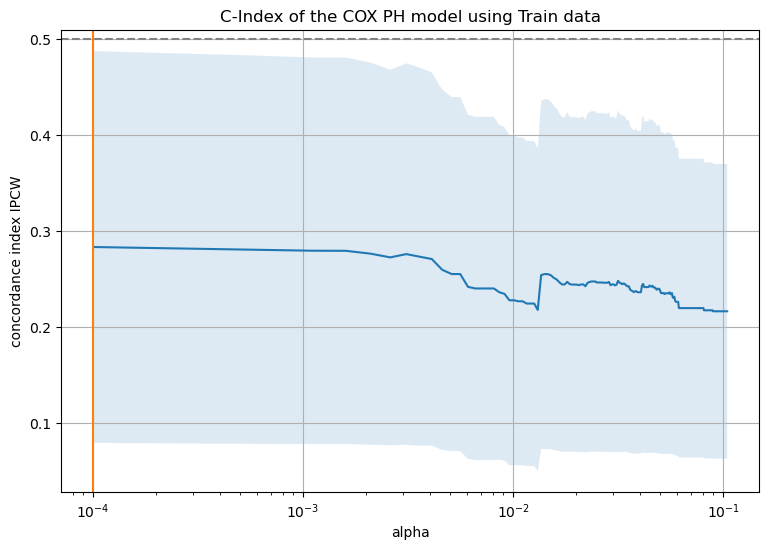

In [96]:
cv_results = pd.DataFrame(gcv.cv_results_)

alphas = cv_results.param_estimator__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

best_model = gcv.best_estimator_.estimator
best_alpha = gcv.best_params_["estimator__alphas"][0]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index IPCW")
ax.set_xlabel("alpha")
ax.axvline(best_alpha, c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)
plt.title("C-Index of the COX PH model using Train data")
plt.show()

In [104]:
va_times = np.arange(1, max(va_y_test['Survival_in_days']), 7)
cph_risk_scores = cph.predict(va_x_test, alpha = 0.01)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Celltype
- Prior_therapy
- Treatment
Feature names seen at fit time, yet now missing:
- Celltype=large
- Celltype=smallcell
- Celltype=squamous
- Prior_therapy=yes
- Treatment=test


In [106]:
1 in [1,2,3]

True

In [105]:
G = cph.predict_survival_function(va_x_test, alpha = None)
predicted_values = []
for g in G:
    color = plt.cm.prism(np.random.rand())  # Random color
    plt.plot(g.x, g.y, color=color, alpha=0.5)

    median_value = np.trapz(g.y, g.x)
    predicted_values += [median_value]
    plt.plot(median_value, 0.5, 'x', color=color, alpha=0.8, markersize=10)
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Celltype
- Prior_therapy
- Treatment
Feature names seen at fit time, yet now missing:
- Celltype=large
- Celltype=smallcell
- Celltype=squamous
- Prior_therapy=yes
- Treatment=test


In [2]:
shape = (730, 2860)
shape2 = (730, 64)

# Generate random numbers
x = np.random.rand(*shape)
y = np.random.rand(*shape2)

In [3]:
import numpy

res = numpy.corrcoef(x.T,y.T)[numpy.arange(x.shape[1])[numpy.newaxis,:]
                                 ,numpy.arange(y.shape[1])[:,numpy.newaxis]]
res

array([[ 1.        , -0.03604255, -0.06451636, ...,  0.046663  ,
         0.05436976,  0.02786433],
       [-0.03604255,  1.        , -0.02628672, ...,  0.00305404,
         0.00575681,  0.01542389],
       [-0.06451636, -0.02628672,  1.        , ...,  0.00835764,
         0.01534823,  0.07311139],
       ...,
       [ 0.01770533,  0.02450881,  0.03253604, ...,  0.04634739,
         0.02738794,  0.02026871],
       [ 0.0372959 , -0.11189343, -0.00334044, ...,  0.02746977,
        -0.0123697 ,  0.00612065],
       [-0.00844195, -0.01870446,  0.01925863, ...,  0.0103671 ,
        -0.01288313, -0.01619312]])

In [131]:
res.shape

(64, 2860)

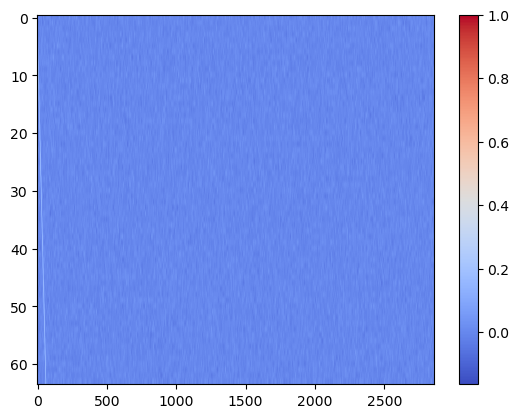

In [134]:
plt.imshow(res, cmap='coolwarm', aspect='auto')

# Add colorbar for reference
plt.colorbar()

# Show plot
plt.show()